In [2]:
import uproot as uproot
import numpy as np
import awkward as ak
print(uproot.__version__)
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.special import exp10
print(mpl.__version__)
import sys

sys.path.append("/home/amisery/Analysis_mlcut")
from train_test_tree import CutEngine
from bdt_analysis import BDTAnalysis
from utils import return_cuts, read_folder, plot_sig_bg_2d_comp, plot_2d_tp_tn_fp_fn, print_sel_comp
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

4.3.7
3.6.2


In [3]:
latex_legends = [r'True $\nu_{e}~CC0\pi$', r"True entering $\gamma$", r'True NC $\gamma$', r'True NC $\pi^0$',  r'True NC $~$', r'True $\nu_{\mu, ws}$', r'True $\nu_{\mu}$', r'True $\nu_{e}~CC~other$', r'True $\nu_{e, ws}$', "other"]


In [4]:
%load_ext autoreload
%autoreload 2

# 1 - Data preparation

In [5]:
df = read_folder(fpath = "/home/amisery/Analysis/RecoAnalysis/outputs/data/data_all_precut_newcond/")

In [6]:
df

,pmu,ppi0,pe,pgamma,mom,sig,sig_fitqun,dwall,towall,trueoaa,pi0mass,reac,pi0likelihood,reconring,pi0fitqun,weight
0,1.000000e+00,0.000000e+00,6.929645e-18,0.000000e+00,965.568176,0.0,0.0,149.321411,622.982239,2.319337,230.666504,6.0,1019.482422,2.0,0.0,0.610889
1,4.327069e-15,7.711124e-01,7.664759e-02,1.522400e-01,437.999603,0.0,0.0,77.508728,391.893951,2.368603,48.830944,3.0,184.047852,1.0,1.0,0.610889
2,9.999989e-01,8.028039e-33,1.018091e-06,1.164838e-17,392.912689,0.0,0.0,126.381226,684.724487,2.493949,62.692978,6.0,105.805664,2.0,0.0,0.610889
3,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1854.457886,0.0,0.0,68.214966,633.339050,2.206555,149.502579,7.0,541.140625,2.0,0.0,0.610889
4,4.305056e-06,1.576495e-01,2.716366e-01,5.707096e-01,155.639130,0.0,0.0,79.199890,338.276550,2.396207,14.802931,3.0,119.750000,2.0,0.0,0.610889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2304.942383,0.0,0.0,60.031006,484.421143,2.559561,291.632874,8.0,223.800781,2.0,0.0,0.610889
1235,1.190365e-05,4.744078e-02,7.431487e-01,2.093985e-01,523.488770,1.0,1.0,127.631866,245.047989,2.391793,7.857716,0.0,126.613281,1.0,1.0,0.610889
1236,9.999996e-01,2.131149e-35,3.624152e-07,5.228750e-19,119.655640,0.0,0.0,264.692139,465.924194,2.428016,1.576376,6.0,11.199219,2.0,1.0,0.610889
1237,1.441160e-04,3.932545e-01,3.484206e-01,2.581807e-01,529.013611,1.0,1.0,125.414917,187.976089,2.514116,35.111214,0.0,221.499023,1.0,1.0,0.610889


Let's add two columns to the dataset corresponding to the MLxFitQun and ML only (by hands) selection, and apply the basic cuts

In [7]:
base_cut = (df["dwall"]>100)  & (df["reconring"] == 1)

In [8]:
df_base = df[base_cut]
pmu_base_cut, pi0_base_cut, pe_cut, pi0_fitqun_cut = return_cuts(df_base)
mixed_cut = pmu_base_cut & pi0_fitqun_cut
ml_cut = pmu_base_cut & pi0_base_cut & pe_cut
df_base["sig_mixed"] = mixed_cut
df_base["sig_ml"] = ml_cut

/tmp/ipykernel_22267/2256953893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["sig_mixed"] = mixed_cut
/tmp/ipykernel_22267/2256953893.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base["sig_ml"] = ml_cut


# 2 - GBDT training
In this part, we will investigate the training and performance of our GBDT. We plot precision recall, and event selection per class over a series of tests to get averaged values of its performance

In [9]:
def res_analysis(df, train_col = ["pmu", "mom", "ppi0", "pe", "pgamma", "dwall", "sig"]):
    dict_collection = []
    prec_agg, rec_agg = [], []
    for i in range(10):
        cut_engine = CutEngine(df, train_col = train_col, lr = 0.1)
        cut_engine.train()
    #     cut_engine.make_calibration_curve()
        prec_l, rec_l = [], []
        dict_pred = {}
        thresh_chosen = []
        for weight_rec in np.linspace(0.1, 1, 10):
            print(weight_rec)
            test_f1, prec, rec = cut_engine.test(weight_rec = weight_rec)
            prec_l.append(prec)
            rec_l.append(rec)
            print(cut_engine.get_features_importances())
            thresh_chosen.append(cut_engine.best_thresh)

            df["sig_gbdt"] = cut_engine.get_pred_labels()
            df_cut = df.iloc[cut_engine.X_v.index]
#             basic_scoring(df_cut,"sig_gbdt")
#             basic_scoring(df_cut,"sig_fitqun")
#             basic_scoring(df_cut,"sig_mixed")

#             print_sel_comp(df_cut,"sig_gbdt", "sig_mixed")
            dict_frac = print_sel_comp(df_cut,"sig_gbdt", "sig_fitqun")
            for key in list(dict_frac.keys()):
                if key not in list(dict_pred.keys()):
                    dict_pred[key] = dict_frac[key]
                    
                else : 
                    dict_pred[key] += dict_frac[key]
            
#             df_frac = pd.DataFrame(dict_frac)
#             print(df_frac.head())
#             print_sel_comp(df, "sig_mixed", "sig_fitqun")
        dict_collection.append(dict_pred)
        prec_agg.append(prec_l)
        rec_agg.append(rec_l)

    prec_agg = np.array(prec_agg)
    rec_agg = np.array(rec_agg)
    weight_span = np.linspace(0.1,1,10)
    prec_mean, rec_mean = np.mean(prec_agg, axis = 1), np.mean(rec_agg, axis = 1)
    prec_err, rec_err = np.std(prec_agg, axis = 1), np.std(rec_agg, axis =1)
    plt.errorbar(weight_span, prec_mean, prec_err, label = "Precision")
    plt.errorbar(weight_span, rec_mean, rec_err, label = "Recall")
    plt.plot(weight_span, [0.567 for i in range(10)], label = "FitQun precision", color = "blue", linestyle = ":")
    plt.plot(weight_span, [0.695 for i in range(10)], label = "FitQun recall", color = "orange", linestyle = ":")
    plt.xlabel("Recall weight in F1 score")
    plt.legend()
    plt.show()
    plt.clf()
    return cut_engine, df_cut, dict_collection, thresh_chosen, prec_agg, rec_agg

## Training the model, evaluating the splits

BDTAnalysis is a class to run different analysis on the performance of the model, plotting ...

In [10]:
analysis_bdt = BDTAnalysis(df_base, ["pmu", "mom", "ppi0", "pe", "pgamma", "pi0mass", "sig"])

using gbdt model


Using a fixed recall weight, we analyze and compare the performances to alternative selection methods

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()


prec ML on test : 0.7549889135254989 recall ML on test = 0.7900232018561485
prec FitQun on test : 0.5646511627906977 recall FitQun on test : 0.7041763341067285
[0.72072072 0.70588235 0.33333333        nan        nan]
[0.71084337 0.         0.5               inf        nan]
[0.66666667 0.81818182 1.75       1.         2.        ]
[0.81818182 0.97777778 0.89189189 1.22857143 1.16666667]


/home/amisery/Analysis_mlcut/utils.py:238: RuntimeWarning: invalid value encountered in true_divide
  print(histo1/histo2)
/home/amisery/Analysis_mlcut/utils.py:243: RuntimeWarning: invalid value encountered in long_scalars
  vals_y = np.concatenate((vals_y,np.array([histo1[j]/histo2[j] for i in range(10)])))
/home/amisery/Analysis_mlcut/utils.py:238: RuntimeWarning: divide by zero encountered in true_divide
  print(histo1/histo2)
/home/amisery/Analysis_mlcut/utils.py:243: RuntimeWarning: divide by zero encountered in long_scalars
  vals_y = np.concatenate((vals_y,np.array([histo1[j]/histo2[j] for i in range(10)])))


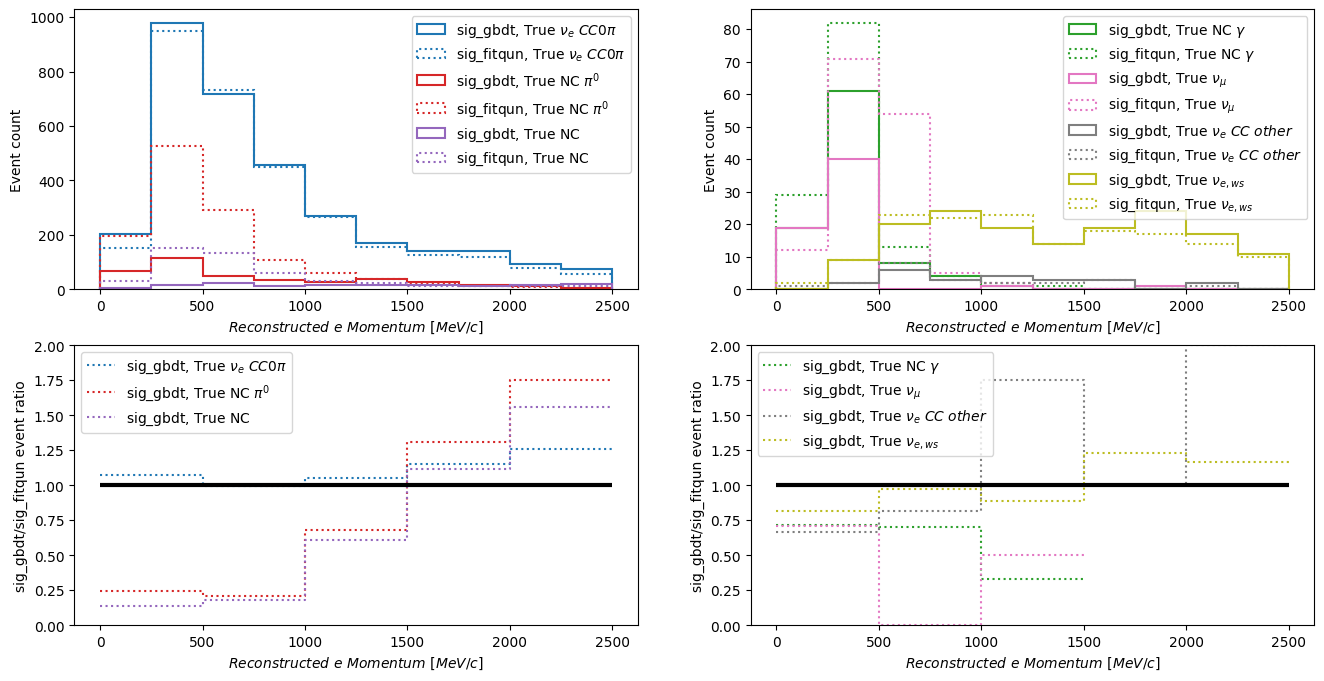

<Figure size 640x480 with 0 Axes>

prec mixed on test : 0.5780821917808219 recall mixed on test : 0.734338747099768
[0.62015504 0.70588235 0.33333333        nan        nan]
[0.49579832 0.         0.5               inf        nan]
[1.         0.81818182 1.75       1.         2.        ]
[0.75       1.         0.89189189 1.22857143 1.16666667]


/home/amisery/Analysis_mlcut/utils.py:238: RuntimeWarning: invalid value encountered in true_divide
  print(histo1/histo2)
/home/amisery/Analysis_mlcut/utils.py:243: RuntimeWarning: invalid value encountered in long_scalars
  vals_y = np.concatenate((vals_y,np.array([histo1[j]/histo2[j] for i in range(10)])))
/home/amisery/Analysis_mlcut/utils.py:238: RuntimeWarning: divide by zero encountered in true_divide
  print(histo1/histo2)
/home/amisery/Analysis_mlcut/utils.py:243: RuntimeWarning: divide by zero encountered in long_scalars
  vals_y = np.concatenate((vals_y,np.array([histo1[j]/histo2[j] for i in range(10)])))


<Figure size 640x480 with 0 Axes>

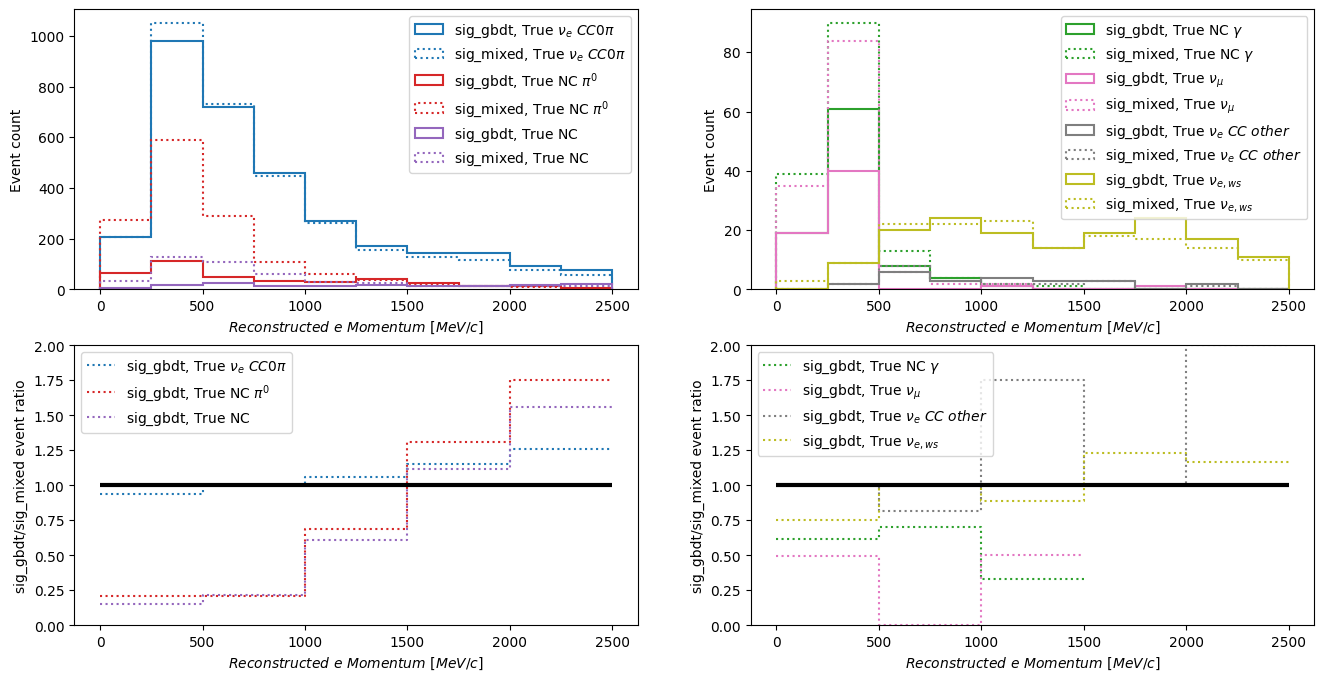

<Figure size 640x480 with 0 Axes>

prec ML only on test : 0.6838453914767096 recall ML only on test : 0.8004640371229699
[0.86956522 0.92307692 0.33333333        nan        nan]
[0.71084337        nan 0.25       1.         0.        ]
[1.  0.9 0.7 1.  1. ]
[1.         1.04761905 0.6875     0.89583333 0.93333333]


/home/amisery/Analysis_mlcut/utils.py:238: RuntimeWarning: invalid value encountered in true_divide
  print(histo1/histo2)
/home/amisery/Analysis_mlcut/utils.py:243: RuntimeWarning: invalid value encountered in long_scalars
  vals_y = np.concatenate((vals_y,np.array([histo1[j]/histo2[j] for i in range(10)])))


<Figure size 640x480 with 0 Axes>

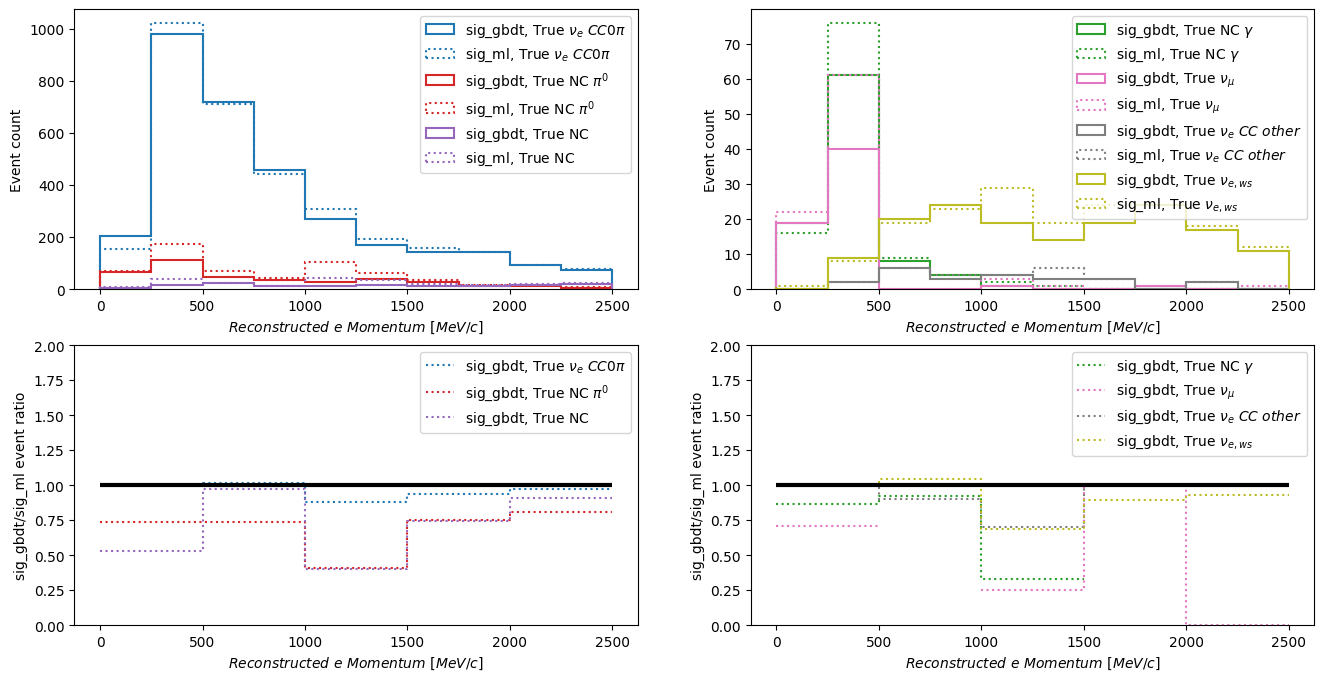

<Figure size 640x480 with 0 Axes>

{'True $\\nu_{e}~CC0\\pi$': [1.0757714634891538], 'True NC $\\pi^0$': [0.3256172839506173], 'True NC $~$': [0.43920145190562615], 'True NC $\\gamma$': [0.7099236641221374], 'True $\\nu_{\\mu}$': [0.4236111111111111], 'True $\\nu_{e}~CC~other$': [1.0454545454545454], 'True $\\nu_{e, ws}$': [1.0102564102564102]} {'True $\\nu_{e}~CC0\\pi$': [3521, 3273], 'True NC $\\pi^0$': [422, 1296], 'True NC $~$': [242, 551], 'True NC $\\gamma$': [93, 131], 'True $\\nu_{\\mu}$': [61, 144], 'True $\\nu_{e}~CC~other$': [23, 22], 'True $\\nu_{e, ws}$': [197, 195]}


(0.7723184908971266, 0.8101702715140359)

<Figure size 640x480 with 0 Axes>

In [11]:
analysis_bdt.train_at_fixed_weight(0.45)

We can study the importance of each feature with Maximum Impurity Decrease (MID). Surprisingly, $P(\mu)$ and $P(\pi^0)$ play the least important role !

In [12]:
analysis_bdt.cut_engine.get_features_importances()

{'pmu': 0.05691136374648657,
 'mom': 0.3249417020434827,
 'ppi0': 0.05041301701800325,
 'pe': 0.36084397774053834,
 'pgamma': 0.08754028192884099,
 'pi0mass': 0.11934965752264824}

Let's look at how the model splits data in the 2D space of previously shown histograms

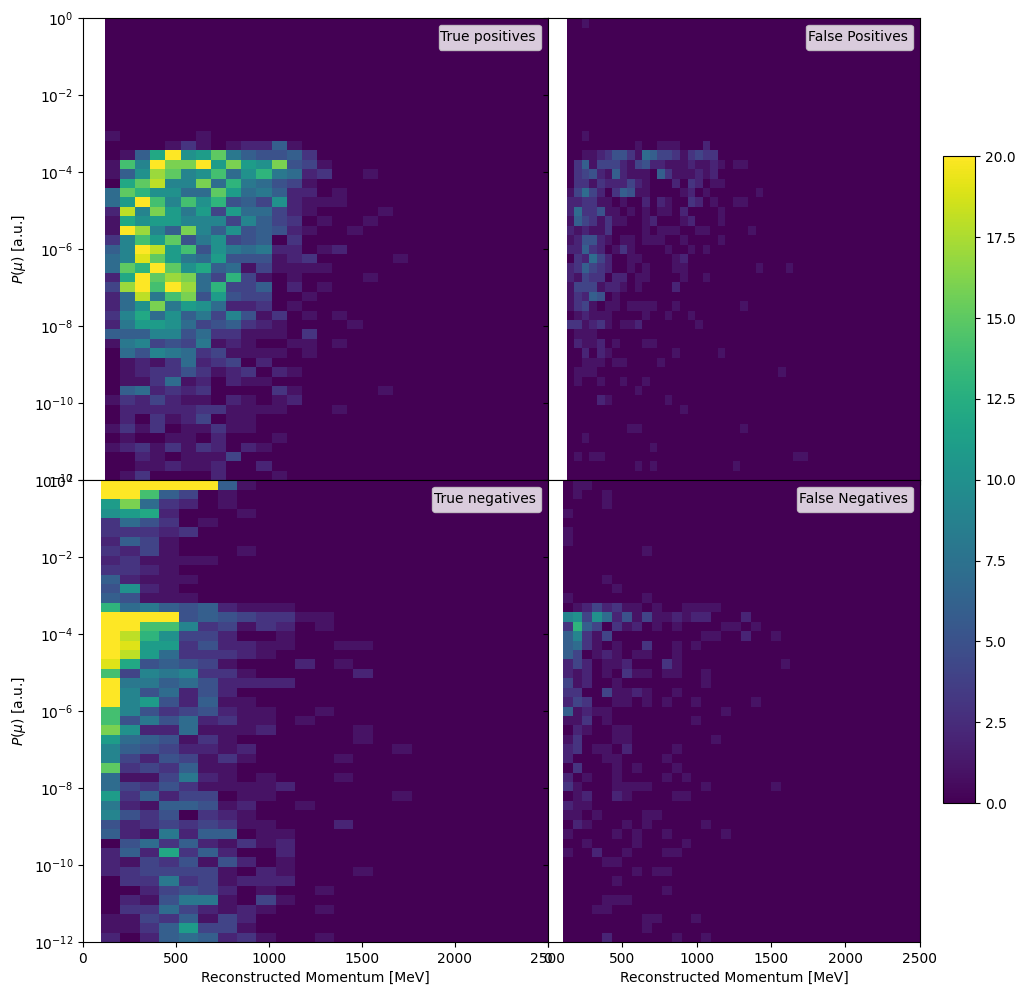

In [13]:
analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_gbdt","mom", "pmu",  xlim = (0,2500), ylim = (1e-12,1), vmax = 20, logbin_y = True, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(\mu)$ [a.u.]")

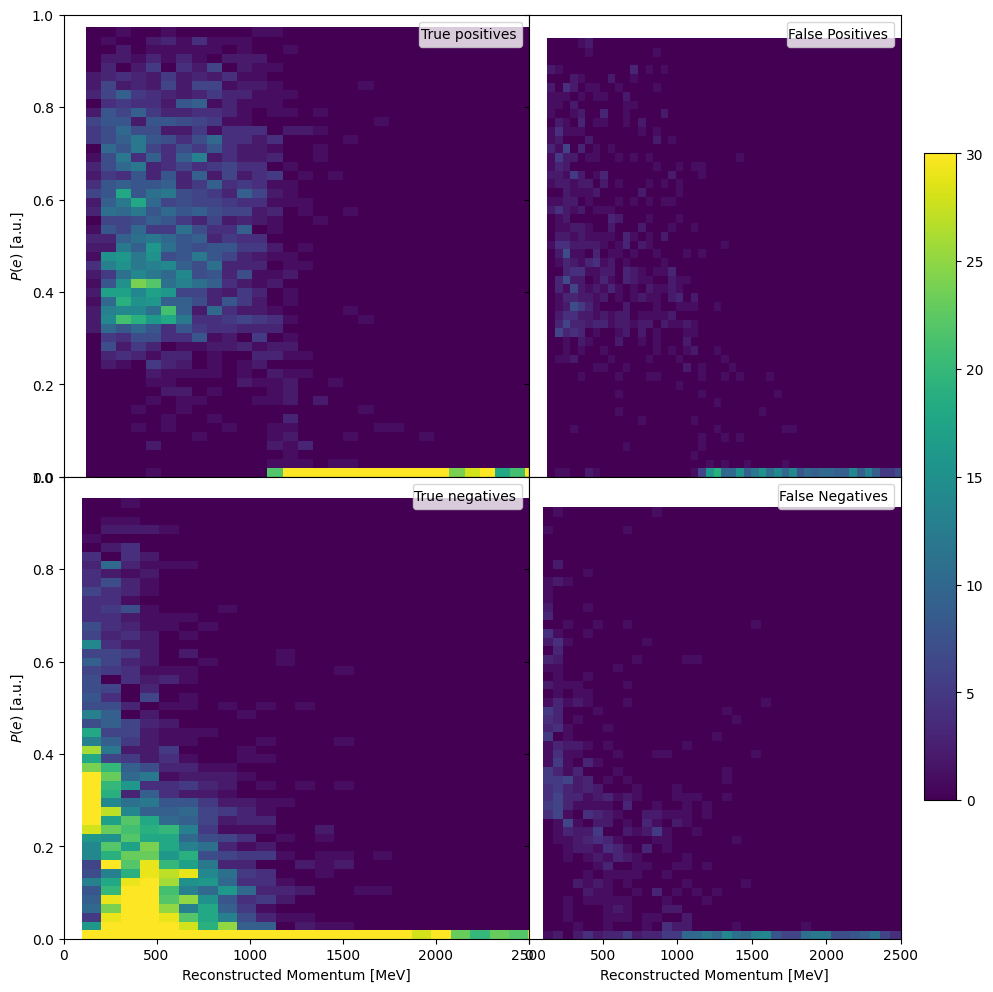

In [14]:
analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_gbdt", "mom", "pe", xlim = (0,2500), ylim = (1e-12,1), vmax = 30, logbin_y = False, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(e)$ [a.u.]")

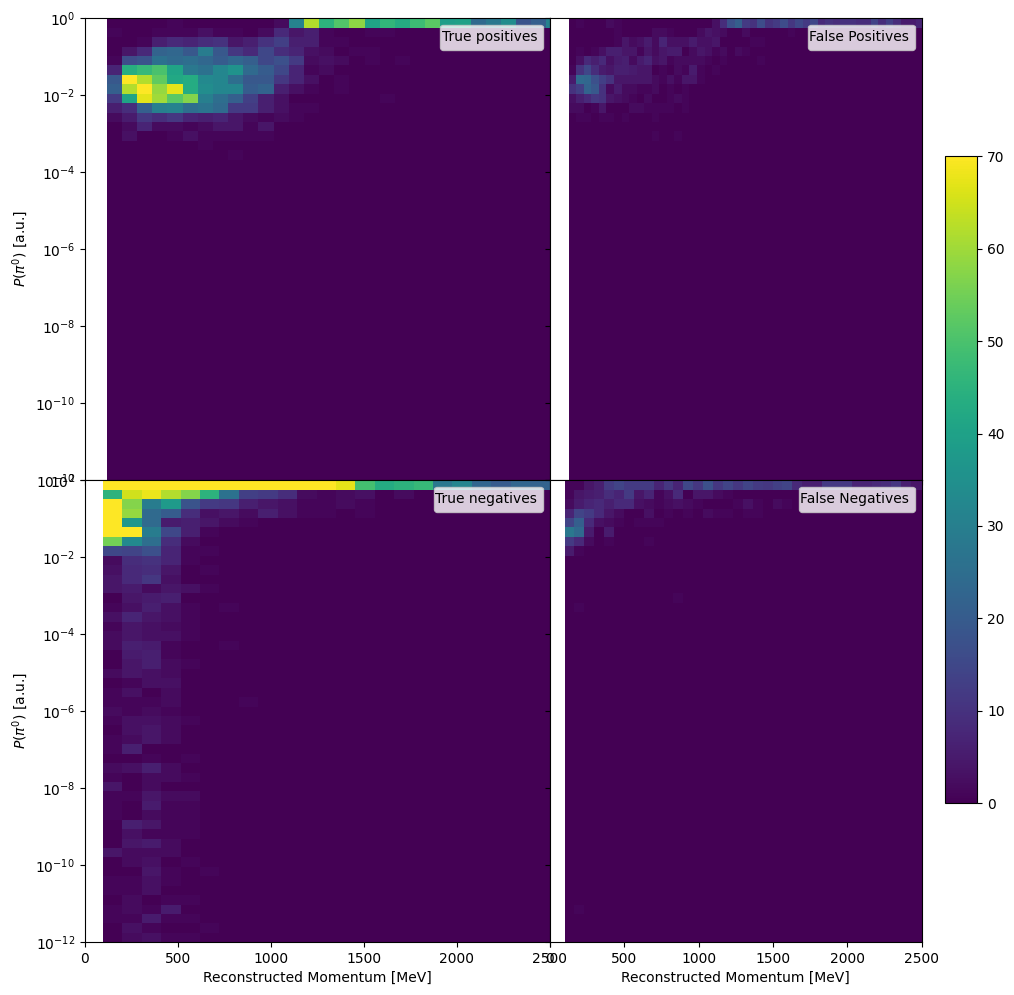

In [15]:
 analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_gbdt", "mom", "ppi0", xlim = (0,2500), ylim = (1e-12,1), vmax = 70, logbin_y = True, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(\pi^0)$ [a.u.]")

We can plot the same thing for the hand tuned ML cut and compare the selections : 

In [ ]:
analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_ml","mom", "pmu",  xlim = (0,2500), ylim = (1e-12,1), vmax = 20, logbin_y = True, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(\mu)$ [a.u.]")

In [ ]:
analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_ml", "mom", "pe", xlim = (0,2500), ylim = (1e-12,1), vmax = 30, logbin_y = False, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(e)$ [a.u.]")

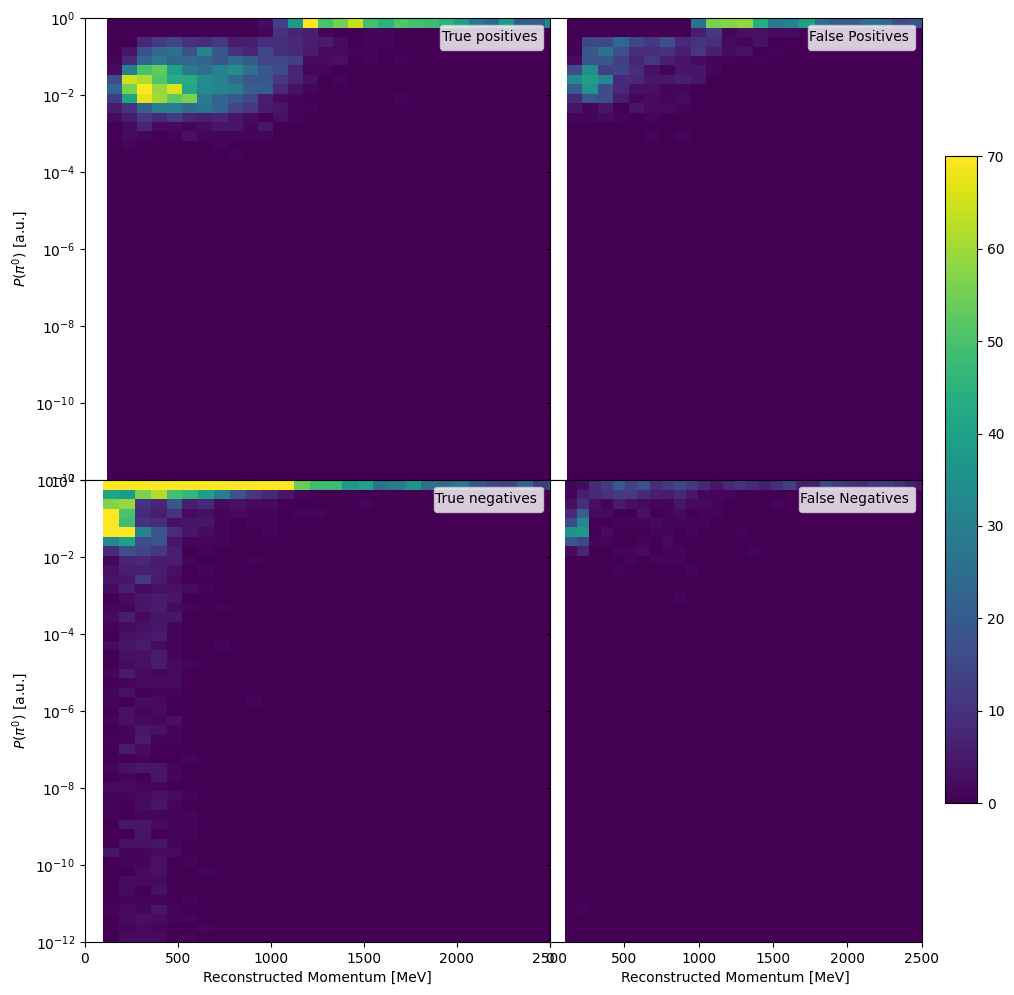

In [18]:
 analysis_bdt.plot_2d_tp_tn_fp_fn(analysis_bdt.df, "sig_ml", "mom", "ppi0", xlim = (0,2500), ylim = (1e-12,1), vmax = 70, logbin_y = True, xname = r"Reconstructed Momentum [MeV]", yname = r"$P(\pi^0)$ [a.u.]")

## Performances and recall weight tuning
Let's justify our choice of 0.4 for the recall weight by plotting the event selection rates as well as the precision/recall evolution as a function of the threshold

In [19]:
cut_engine, df_cut, dict_collection, thresh_chosen, prec_l, rec_l = analysis_bdt.error_on_split()

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

using gbdt model


/home/amisery/Analysis_mlcut/bdt_analysis.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df["sig_gbdt"] = self.cut_engine.get_pred_labels()
/home/amisery/Analysis_mlcut/bdt_analysis.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sig_gbdt"] = self.cut_engine.get_pred_labels()


KeyboardInterrupt: 